## Stochastic Block Modeling
Stochastic Block Modeling is a method for detecting community structure within graphs. If you're familiar with something like the [Louvain Method](https://en.wikipedia.org/wiki/Louvain_Modularity), prepare for SBMs to blow your mind. SBMs are helpful because they allow for statistical inference on the graph, giving you information about the structure and data generation process.

One downside to the Louvain method is that it's algorithmic and non-deterministic: it aims to optimize some value (Modulatiry) by randomly selecting a starting node and checking if "merging" these two nodes increases this value. This doesn't tell you anything about how the data was generated or the network structure, it's just a set of rules to end up with a community assignment for each node that is fairly sensible.

Stochastic Block Modeling, on the other hand, requires some assumptions up front. If you have community structure in your graph, you're essentially already making these assumptions in trying to infer the communities. The assumptions are:

1. There are $B$ blocks.
2. Nodes in block $B_{i}$ are connected to nodes in block $B_{j}$ with some probability $p_{ij}$

That's it! 

<img src="https://media1.tenor.com/images/b27c8efb05cb7a3a09aae2497cae25c6/tenor.gif?itemid=9592017">

You can also use SBMs to uncover hierarchical community structure. So you'll have communities that are themselves a part of a larger community. 

The best part about this is that we can analyze every level of this hierarchy as a network. At the lowest level, our nodes are still our nodes. As we move up the hierarchy, the communities become nodes, and you can use the $p_{ij}$ as an edge weight. This allows you to understand the community structure through the same lens as you're analyzing your lowest level node structure.

In [1]:
# import pandas before graph-tool
# see: https://github.com/pandas-dev/pandas/issues/19706#issuecomment-367788191

import pandas as pd 
import graph_tool.all as gt
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
largest_comp = gt.load_graph("./data/ira_largest_component.gt")

### Using Edge Weights
For our SBM, we'll use the $log(n\ mentions)$ as our edge weights to simplify the analysis. We'll have to specify a distribution for the weights -- we'll just use `real-normal` for simplicity.

Another nice advantage of `graph-tool`'s implementation of SBM's is that you can use multiple edge weights and multiple distributions for each weight to direct the block modeling.

In [3]:
%%time
state_args = dict(recs=[largest_comp.ep["mention_weights_log"]],
                  rec_types=["real-normal"])
state_nested = gt.minimize_nested_blockmodel_dl(largest_comp,
                                                state_args=state_args)

CPU times: user 24min 46s, sys: 1.58 s, total: 24min 47s
Wall time: 22min 48s


In [4]:
state_nested.print_summary()

l: 0, N: 2664, B: 31
l: 1, N: 31, B: 7
l: 2, N: 7, B: 2
l: 3, N: 2, B: 1


## Visualizing all levels of the hierarchical assignments
In the plots below, we'll color the nodes by the block assigned to that node for each level of the hierarchical model. We'll start with the most granular level and move up the tree.

Level: 0


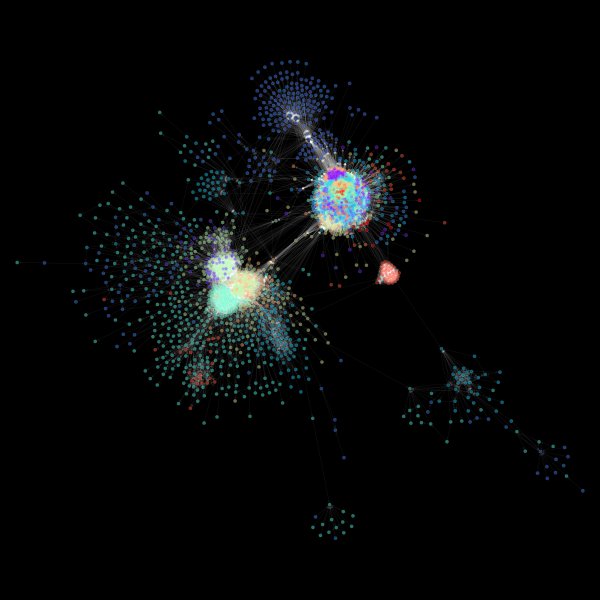

Level: 1


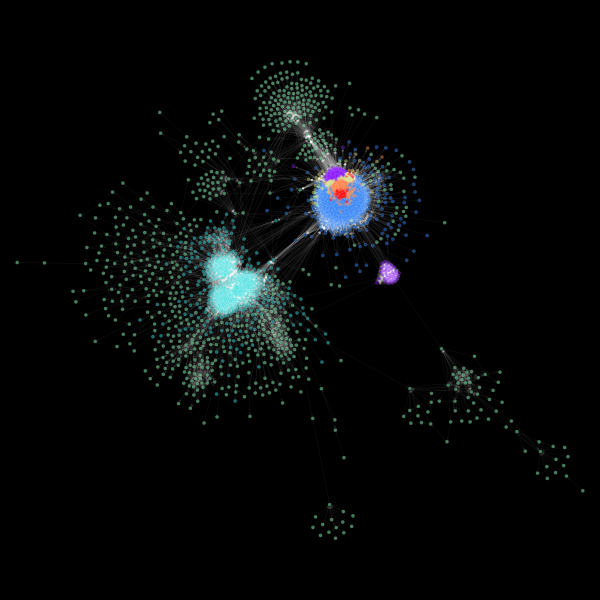

Level: 2


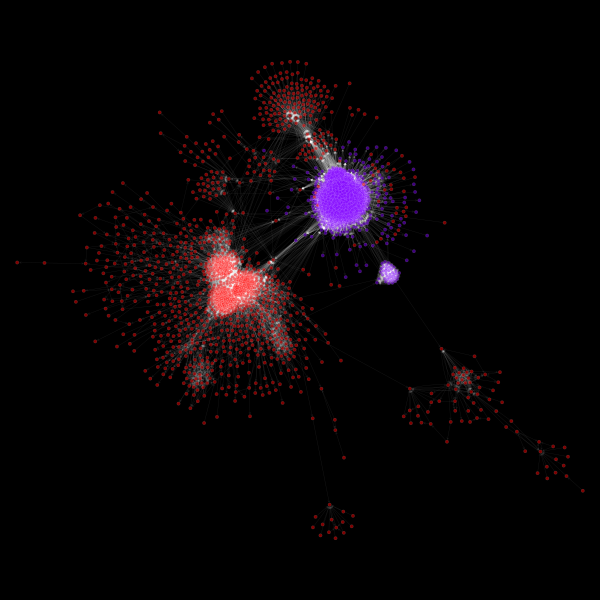

In [5]:
for i in range(len(state_nested.levels)-1):
    block_projection = state_nested.project_partition(i, 0)
    print("Level:", i)
    gt.graph_draw(
        largest_comp,
        pos=largest_comp.vp.pos,
        output_size=(600, 600),
        edge_color=[1, 1, 1, .1],
        vertex_fill_color=block_projection,
        vcmap=(matplotlib.cm.rainbow, .5),
        vertex_color=[1, 1, 1, .2],
        bg_color=[0,0,0,1]
    )

## Large Visualization of Level 0 Block Assignments
We'll make a large visualization of the lowest level of the block assignments that will allow us to zoom into certain nodes and investigate the block structure.

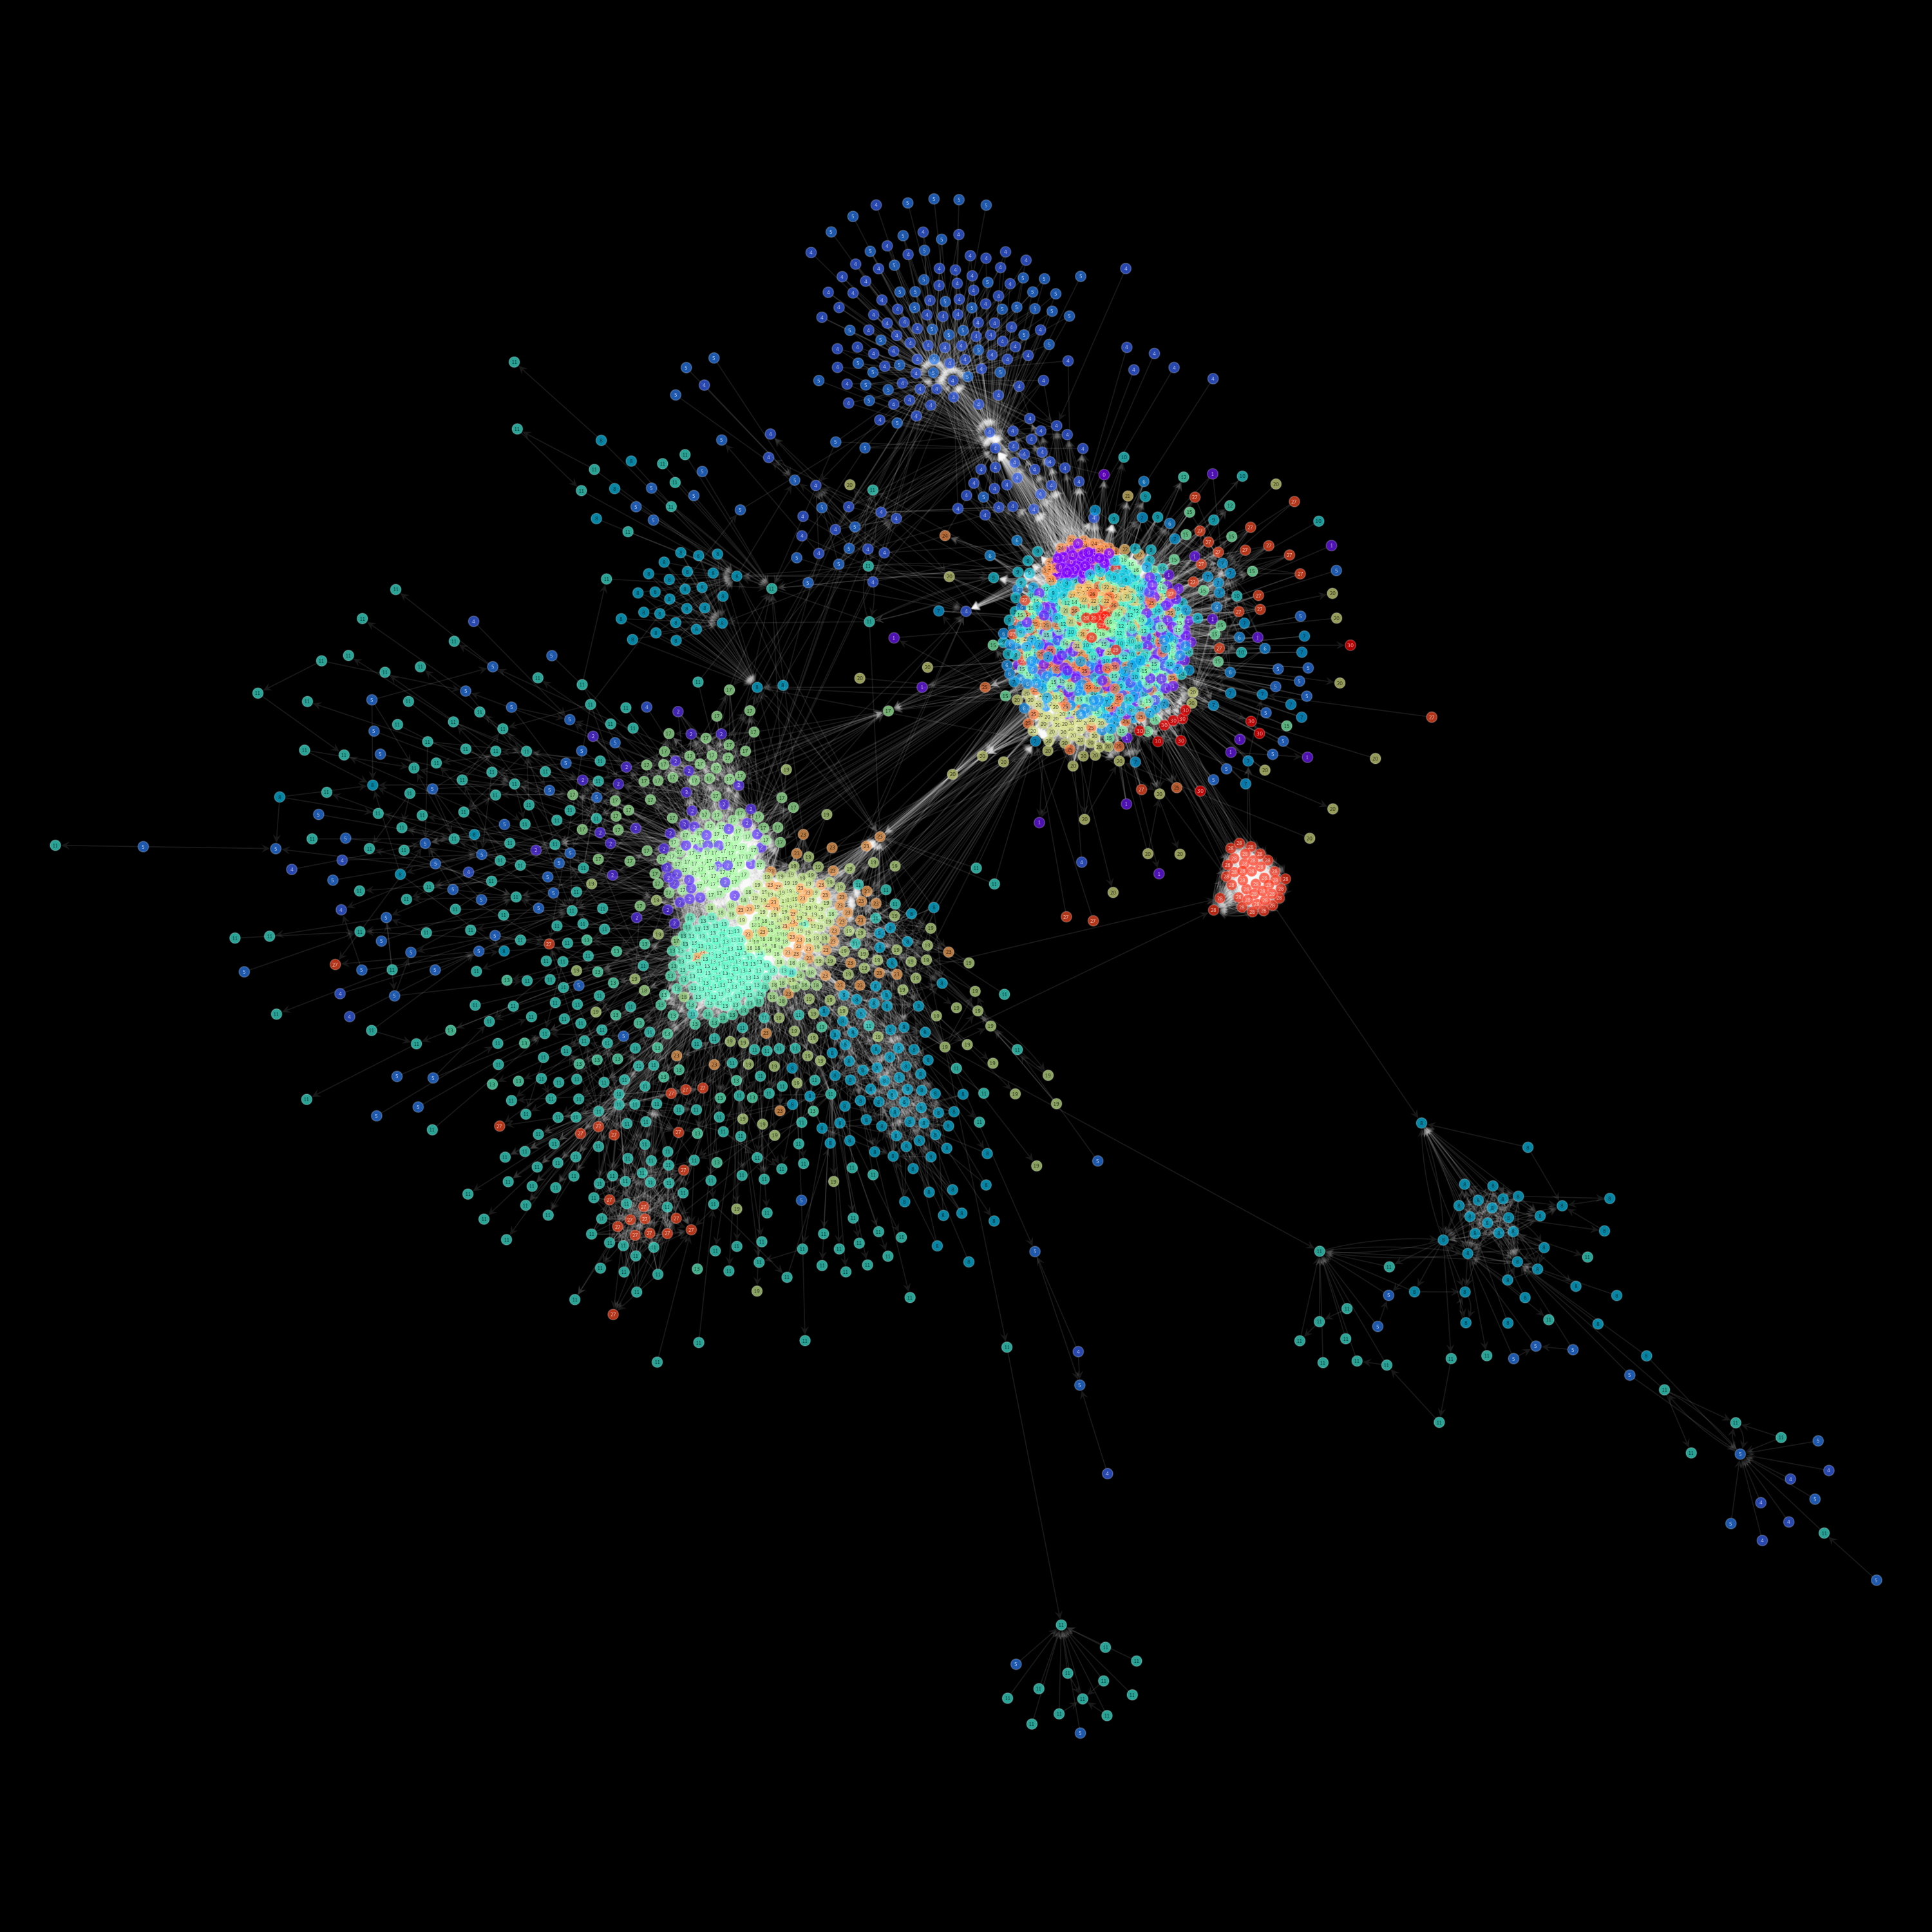

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa3a6a4c6a0, at 0x7fa3a6a4cc18>

In [6]:
block_projection = state_nested.project_partition(0, 0)

gt.graph_draw(
    largest_comp,
    pos=largest_comp.vp.pos,
    output_size=(3000, 3000),
    edge_color=[1, 1, 1, .1],
    vertex_fill_color=block_projection,
    vcmap=(matplotlib.cm.rainbow, .7),
    vertex_color=[1, 1, 1, .2],
    vertex_text=block_projection,
    vertex_font_size=8,
    bg_color=[0,0,0,1]
)

## Relationships Between Blocks
Below, we'll plot the $p_{ij}$ value between each block. Again, this is the probability of two nodes in two different blocks having a relationship. We can also evaluate the intra-block density along the diagonal: for example, if $p_{ii} = 1$, then each node in block $i$ must be connected to every other node in block $i$.

Also keep in mind that the relationships are not symmetric given that we have a directed graph (`UserA` can mention `UserB`, but that's not a guarantee of the reciporical relationship).

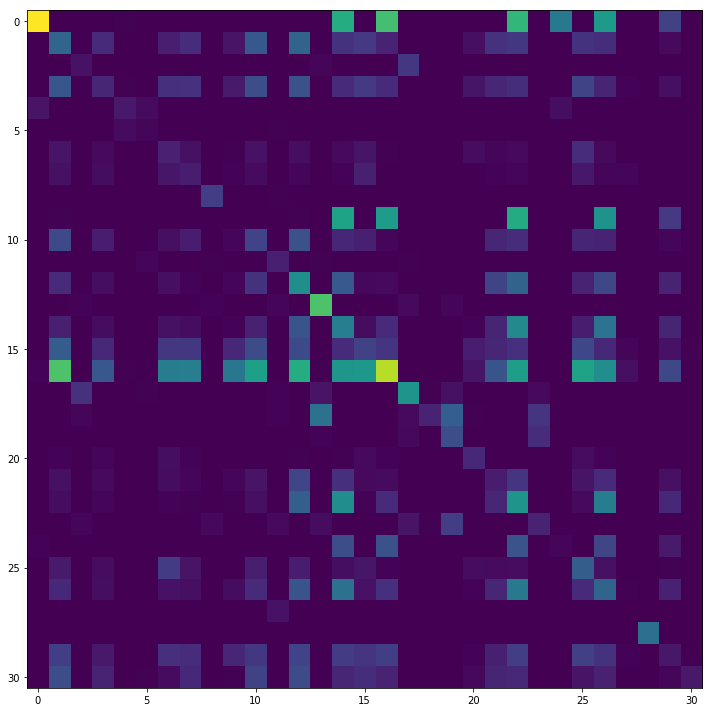

In [7]:
l_0 = state_nested.get_levels()[0]
adj_matrix = l_0.get_matrix()

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(adj_matrix.todense(), aspect="auto")
plt.tight_layout()

## Block Structure as a Graph
We can take a look at the relationship between blocks as a graph as well.

This illustrates the pocket of dense relationships between nodes in several blocks.

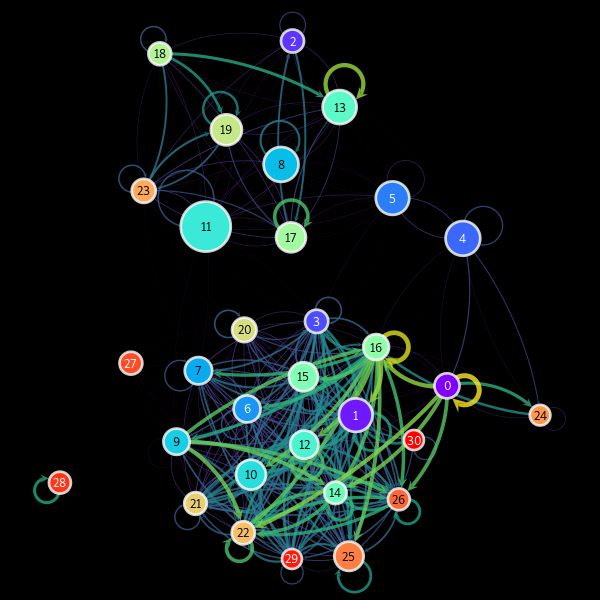

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa360e8ceb8, at 0x7fa35f5f9f60>

In [8]:
l_1 = state_nested.get_levels()[1]
eprop_l = l_1.g.new_edge_property("int")
for edge in list(l_1.g.get_edges()):
    source, target = edge[0], edge[1]
    eprop_l[l_1.g.edge(source, target)] = adj_matrix[int(edge[0]), int(edge[1])]

block_sizes = l_1.g.new_vertex_property("int", vals=l_0.get_nr().a)

gt.graph_draw(l_1.g,
              vertex_text=l_1.g.vertex_index,
              vertex_fill_color=l_1.g.vertex_index,
              vertex_color=[1,1,1,.8],
              vertex_size=gt.prop_to_size(block_sizes, 20, 50, power=1),
              vcmap=(matplotlib.cm.rainbow, 1),
              ecmap=(matplotlib.cm.viridis, .8),
              eorder=eprop_l,
              edge_pen_width=gt.prop_to_size(eprop_l),
              edge_color=gt.prop_to_size(eprop_l),
              bg_color=[0,0,0,1])

## Hierarchical Graph Visualization
There are some nice visualizations for viewing the nested block model. The `draw_hierarchy()` method will use edge bundling and take advantage of the hierarchical structure to build a cool radial plot. From this we can see our distinct two group structure. I actually prefer the above visualization, but if I could get the block labels to appear on this one, or we had fewer blocks, it could be more useful.

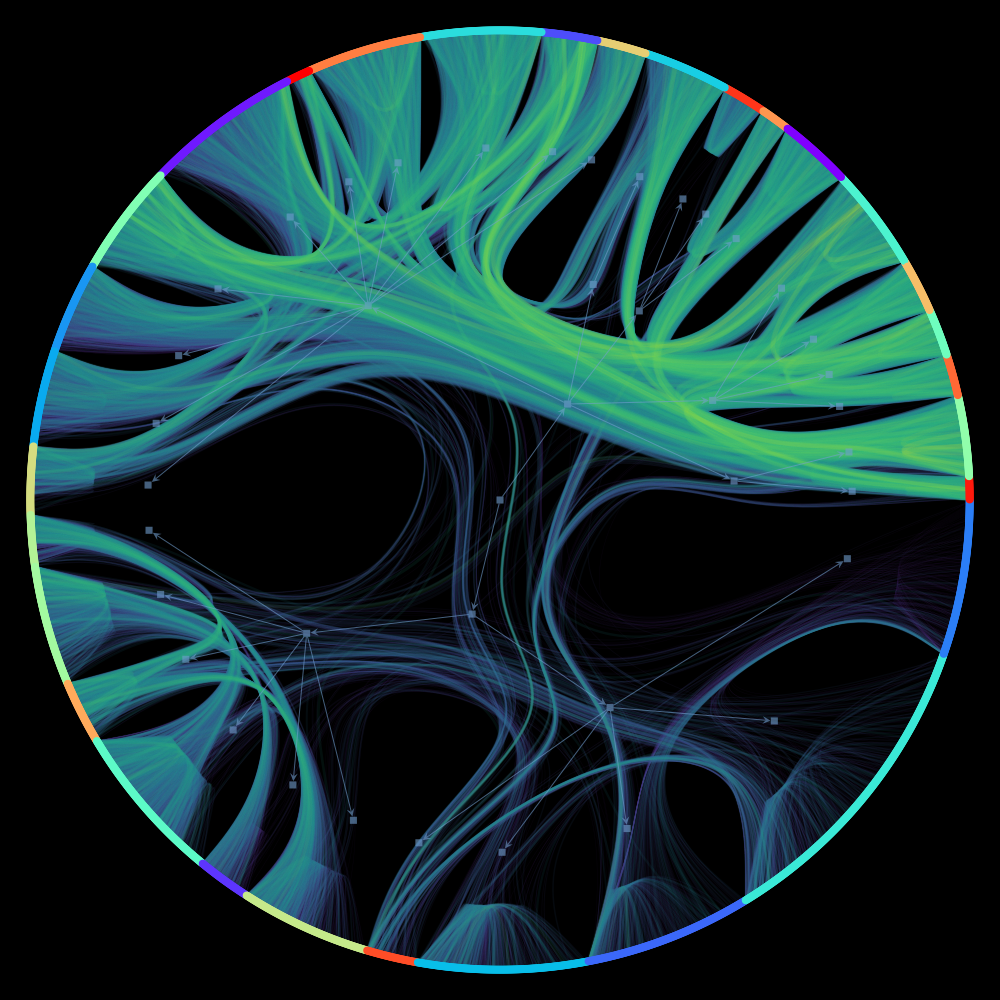

(<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa3a6a4c6a0, at 0x7fa35f5dcc50>,
 <Graph object, directed, with 2705 vertices and 2704 edges at 0x7fa35f5dc7f0>,
 <PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa35f5dc7f0, at 0x7fa35f5dcba8>)

In [9]:
block_projection = state_nested.project_partition(0, 0)

gt.draw_hierarchy(state_nested,
                  deg_size=False,
                  vertex_fill_color=block_projection,
                  vertex_size=8,
                  vertex_color=[0,0,0,0],
                  vcmap=(matplotlib.cm.rainbow, 1),
                  ecmap=(matplotlib.cm.viridis, .1),
                  edge_pen_width=gt.prop_to_size(largest_comp.ep["rt_weights_log"], power=1),
                  edge_color=largest_comp.ep["rt_weights_log"],
                  eorder=largest_comp.ep["rt_weights_log"],
                  edge_gradient=[],
                  output_size=(1000,1000),
                  bg_color=[0,0,0,1])

## Export
We're going to export our data so that we have a block assignment, for each level of the hierarchy, for each node included in our modeling. This will allow us to go back to the original tweet data and join this data so that we can understand the content while also understanding how the accounts are related.

In [10]:
projections = {}
for level in range(len(state_nested.levels)):
    p = state_nested.project_partition(level, 0)
    projections[level] = [p[v] for v in largest_comp.vertices()]
    
index = [largest_comp.vp.vertex_name[v] for v in largest_comp.vertices()]

blocks_df = pd.DataFrame(projections, index=index)

In [11]:
nodes = pd.read_csv("./data/nodes.csv", index_col=0)
node_blocks = nodes.set_index('userid').join(blocks_df).dropna()
col_rename = {i: f"block_{i}" for i in range(len(state_nested.levels))}
node_blocks = node_blocks.rename(columns=col_rename).astype(int)

node_blocks.to_csv("./data/node_blocks.csv")